# Imports

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoProcessor, Llama4ForConditionalGeneration, default_data_collator, get_linear_schedule_with_warmup
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, PrefixTuningConfig
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
import torch
import os
import pandas as pd
import numpy as np

# Parameters

In [132]:
# load csv from data/MELD
raw_train_df = pd.read_csv("data/MELD/train_sent_emo.csv")
raw_valid_df = pd.read_csv("data/MELD/dev_sent_emo.csv")
raw_test_df = pd.read_csv("data/MELD/test_sent_emo.csv")

#take only Utterance and Emotion columns
train_df = raw_train_df[['Dialogue_ID', 'Utterance', 'Emotion']]
valid_df = raw_valid_df[['Dialogue_ID', 'Utterance', 'Emotion']]
test_df = raw_test_df[['Dialogue_ID', 'Utterance', 'Emotion']]



model_name_or_path = "t5-base"
tokenizer_name_or_path = "t5-base"

num_virtual_tokens = 20
max_length = 256

do_train = True
do_eval = True

lr = 1e-3
warmup_ratio=0.1
weight_decay=0.01
num_epochs = 20
batch_size = 20
logging_steps=250
eval_steps=250
save_steps=250
# logging_steps=60
# eval_steps=60
# save_steps=60
dataset_name = "MELD"
output_dir = f"results/{dataset_name}/{model_name_or_path.split('/')[-1]}-peft/lr_{lr}-epochs_{num_epochs}-batch_{batch_size}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_subjects = len(raw_train_df['Emotion'].unique())+1
peft_padding_id = num_subjects*num_virtual_tokens


# integrate model class with dataset

## AbstractPrompt Classes

In [3]:
from peft import PeftModelForSeq2SeqLM, PeftConfig, PromptEncoderReparameterizationType, PromptEncoderConfig
from peft.tuners.prefix_tuning import PrefixEncoder
from peft.tuners.p_tuning import PromptEncoder
from peft.utils import _get_batch_size, TRANSFORMERS_MODELS_TO_PREFIX_TUNING_POSTPROCESS_MAPPING, map_cache_to_layer_device_map, PeftType, TaskType
from transformers import PreTrainedModel, DynamicCache, EncoderDecoderCache
from typing import Optional
import torch
import numpy as np
import warnings
from dataclasses import dataclass, field
import enum
from peft.mapping import MODEL_TYPE_TO_PEFT_MODEL_MAPPING
from typing import Union, List, Dict, Any


@dataclass
class AbstractPromptEncoderConfig(PromptEncoderConfig):
    """
    This is the configuration class to store the configuration of a [`PromptEncoder`].

    Args:
        encoder_reparameterization_type (Union[[`PromptEncoderReparameterizationType`], `str`]):
            The type of reparameterization to use.
        encoder_hidden_size (`int`): The hidden size of the prompt encoder.
        encoder_num_layers (`int`): The number of layers of the prompt encoder.
        encoder_dropout (`float`): The dropout probability of the prompt encoder.
    """

    num_subjects: int = field(
        default=8,
        metadata={"help": "The number of subjects of the prompt encoder"},
    )
    padding_idx: int = field(
        default=None,
        metadata={"help": "The padding index of the prompt encoder"},
    )
    def __post_init__(self):
        super().__post_init__()
        self.peft_type = PeftType.AP_Tuning


class AbstractPromptEncoder(PromptEncoder):
    def __init__(self, config):
        super().__init__(config)
        self.num_subjects = config.num_subjects
        self.total_virtual_tokens = config.num_virtual_tokens * config.num_subjects * config.num_transformer_submodules
        if config.padding_idx is not None:
            self.padding_idx = config.padding_idx
        else:
            self.padding_idx = self.total_virtual_tokens
            self.total_virtual_tokens += 1

        # embedding
        self.embedding = torch.nn.Embedding(self.total_virtual_tokens, self.token_dim, padding_idx=self.padding_idx)
        if not config.inference_mode:
            if self.encoder_type == PromptEncoderReparameterizationType.LSTM:
                lstm_dropout = config.encoder_dropout
                num_layers = config.encoder_num_layers
                # LSTM
                self.lstm_head = torch.nn.LSTM(
                    input_size=self.input_size,
                    hidden_size=self.hidden_size,
                    num_layers=num_layers,
                    dropout=lstm_dropout,
                    bidirectional=True,
                    batch_first=True,
                )

                self.mlp_head = torch.nn.Sequential(
                    torch.nn.Linear(self.hidden_size * 2, self.hidden_size * 2),
                    torch.nn.ReLU(),
                    torch.nn.Linear(self.hidden_size * 2, self.output_size),
                )

            elif self.encoder_type == PromptEncoderReparameterizationType.MLP:
                encoder_num_layers_default = PromptEncoderConfig.encoder_num_layers
                if config.encoder_num_layers != encoder_num_layers_default:
                    warnings.warn(
                        f"for {self.encoder_type.value}, the argument `encoder_num_layers` is ignored. "
                        f"Exactly {encoder_num_layers_default} MLP layers are used."
                    )
                layers = [
                    torch.nn.Linear(self.input_size, self.hidden_size),
                    torch.nn.ReLU(),
                    torch.nn.Linear(self.hidden_size, self.hidden_size),
                    torch.nn.ReLU(),
                    torch.nn.Linear(self.hidden_size, self.output_size),
                ]
                self.mlp_head = torch.nn.Sequential(*layers)

            else:
                raise ValueError("Prompt encoder type not recognized. Please use one of MLP (recommended) or LSTM.")


class AbstractPeftModelForSeq2SeqLM(PeftModelForSeq2SeqLM):
    def __init__(self, model: torch.nn.Module, peft_config: PeftConfig, adapter_name: str = "default", **kwargs):
        super().__init__(model, peft_config, adapter_name, **kwargs)
        self.model = model
        # self.peft_config = peft_config

    def _setup_prompt_encoder(self, adapter_name: str):
        config = self.peft_config[adapter_name]
        if not hasattr(self, "prompt_encoder"):
            self.prompt_encoder = torch.nn.ModuleDict({})
            self.prompt_tokens = {}
        transformer_backbone = None
        for name, module in self.base_model.named_children():
            for param in module.parameters():
                param.requires_grad = False
            if isinstance(module, PreTrainedModel):
                # Make sure to freeze Tranformers model
                if transformer_backbone is None:
                    transformer_backbone = module
                    self.transformer_backbone_name = name
        if transformer_backbone is None:
            transformer_backbone = self.base_model

        if config.num_transformer_submodules is None:
            config.num_transformer_submodules = 2 if config.task_type in [TaskType.SEQ_2_SEQ_LM, TaskType.ABS_SEQ_2_SEQ_LM] else 1

        # determine the word embeddings
        word_embeddings = None
        try:
            # First try to find the word embeddings based on the module name, this should work for models like Bert,
            # Roberta, Deberta, etc.
            word_embeddings = self.base_model.get_submodule("embeddings.word_embeddings")
        except AttributeError:
            pass

        if word_embeddings is None:
            # Word embeddings could not be determined. Next try to guess them by checking which parameter has the size
            # of the vocab.
            for named_param, value in list(transformer_backbone.named_parameters()):
                # for ZeRO-3, the tensor is sharded across accelerators and deepspeed modifies it to a tensor with shape
                # [0] the actual unsharded shape is stored in "ds_shape" attribute special handling is needed in case
                # the model is initialized in deepspeed.zero.Init() context or HfDeepSpeedConfig has been called before
                # For reference refer to issue: https://github.com/huggingface/peft/issues/996
                deepspeed_distributed_tensor_shape = getattr(value, "ds_shape", None)

                if value.shape[0] == self.base_model.config.vocab_size or (
                    deepspeed_distributed_tensor_shape is not None
                    and deepspeed_distributed_tensor_shape[0] == self.base_model.config.vocab_size
                ):
                    word_embeddings = transformer_backbone.get_submodule(named_param.replace(".weight", ""))
                    break

        self.word_embeddings = word_embeddings

        prompt_encoder = AbstractPromptEncoder(config)

        prompt_encoder = prompt_encoder.to(self.device)
        self.prompt_encoder.update(torch.nn.ModuleDict({adapter_name: prompt_encoder}))
        
        self.prompt_tokens[adapter_name] = torch.arange(
            config.num_virtual_tokens * config.num_subjects * config.num_transformer_submodules
        ).long()

    def get_prompt(self, batch_size: int, object_ids: Optional[torch.Tensor] = None, object_tokens: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Returns the virtual prompts to use for Peft. Only applicable when using a prompt learning method.

        The object_ids should be a tensor of shape 
        """
        peft_config = self.active_peft_config
        prompt_encoder = self.prompt_encoder[self.active_adapter]
        # arrange the prompt tokens according to the object id
        if object_tokens is not None:
            prompt_tokens = object_tokens
        elif object_ids is not None:
            object_ids = object_ids.view(batch_size, -1)
            prompt_tokens = (object_ids * peft_config.num_virtual_tokens)[:, :, None] + np.arange(peft_config.num_virtual_tokens)
            # set token id to padding id if it is out of range
            prompt_tokens[prompt_tokens > prompt_encoder.padding_idx] = prompt_encoder.padding_idx
            
        else:
            raise ValueError("object_ids is None, please provide object_ids for AbstractPeftModelForSeq2SeqLM")
        

        if peft_config.inference_mode:
            # prompts = prompt_encoder.embedding.weight
            # TODO: add support for inference mode
            pass
        else:
            prompts = prompt_encoder(prompt_tokens) # (batch_size, num_virtual_tokens, hidden_size)
        return prompts
    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        inputs_embeds=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        decoder_inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        object_tokens=None,

        **kwargs,
    ):
        """
        args:
        object_ids: (batch_size, num_subjects) tensor of object ids. The object ids are used to select the prompt tokens. Not implemented
        object_tokens: (batch, lengths) tensor of object tokens. The object tokens are used to generate the prompt tokens. Should be the same length as prompt tokens.
        """
        peft_config = self.active_peft_config
        batch_size = _get_batch_size(input_ids, inputs_embeds)
        if decoder_attention_mask is not None:
            # concat prompt attention mask
            prefix_attention_mask = torch.ones(batch_size, peft_config.num_virtual_tokens).to(
                decoder_attention_mask.device
            )
            if peft_config.peft_type not in [PeftType.PROMPT_TUNING, PeftType.P_TUNING]:
                decoder_attention_mask = torch.cat((prefix_attention_mask, decoder_attention_mask), dim=1)

        if kwargs.get("position_ids", None) is not None:
            warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")
            kwargs["position_ids"] = None
        if kwargs.get("token_type_ids", None) is not None:
            warnings.warn("Token type ids are not supported for parameter efficient tuning. Ignoring token type ids")
            kwargs["token_type_ids"] = None
        kwargs.update(
            {
                "attention_mask": attention_mask,
                "decoder_attention_mask": decoder_attention_mask,
                "labels": labels,
                "output_attentions": output_attentions,
                "output_hidden_states": output_hidden_states,
                "return_dict": return_dict,
            }
        )

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)

        prompts = self.get_prompt(batch_size=batch_size, object_tokens=object_tokens)
        prompts = prompts.to(inputs_embeds.dtype)

        if inputs_embeds.dim()==3:
            # inputs_embeds: (batch_size, sequence_len, hidden_size)
            # prompts: (batch_size, sequence_len, hidden_size)
            inputs_embeds = inputs_embeds+prompts

        return self.base_model(
            inputs_embeds=inputs_embeds,
            decoder_input_ids=decoder_input_ids,
            decoder_inputs_embeds=decoder_inputs_embeds,
            **kwargs,
        )
    

MODEL_TYPE_TO_PEFT_MODEL_MAPPING["ABS_SEQ_2_SEQ_LM"]=AbstractPeftModelForSeq2SeqLM

In [4]:


peft_config = AbstractPromptEncoderConfig(task_type=TaskType.ABS_SEQ_2_SEQ_LM, inference_mode=False, num_virtual_tokens=20, num_subjects=num_subjects)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 2,018,304 || all params: 224,921,856 || trainable%: 0.8973


# Create next token prediction dataset

In [5]:
# length of the dataset
print(f"train_df: {len(raw_train_df)}")
# check the label types in Emotion
print(raw_train_df['Emotion'].unique())
raw_train_df

train_df: 9989
['neutral' 'surprise' 'fear' 'sadness' 'joy' 'disgust' 'anger']


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


## Tokenize the data

In [108]:
text_column = "Utterance"
label_column = "Emotion"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
emotion_name_to_id = {name:i for i, name in enumerate(raw_train_df['Emotion'].unique())}
emotion_id_to_name = {i:name for i, name in enumerate(raw_train_df['Emotion'].unique())}
emotion_token_to_id = {tuple(tokenizer(name)["input_ids"]):i for i, name in enumerate(raw_train_df['Emotion'].unique())}
# tokenizer(emotion_id_to_name[emotions[j]])["input_ids"]
query_id = len(emotion_name_to_id)

def tokenize_function(examples):
    # print(examples)
    utterance = examples[text_column]
    emotion = examples[label_column]
    utterance_id = tokenizer(utterance, max_length=max_length, padding=False, truncation=False, return_tensors="pt")["input_ids"].view(-1)
    emotion_id = emotion_name_to_id[emotion]
    
    return {"Dialogue_ID":examples["Dialogue_ID"], "UtteranceID": utterance_id, "EmotionID": emotion_id}
    
dialogue_train_df = train_df.apply(
    tokenize_function,
    axis=1,
    result_type="expand",
)
dialogue_train_df = dialogue_train_df.groupby('Dialogue_ID').agg(list).reset_index()

dialogue_eval_df = valid_df.apply(
    tokenize_function,
    axis=1,
    result_type="expand",
)
dialogue_eval_df = dialogue_eval_df.groupby('Dialogue_ID').agg(list).reset_index()


## dataset transformation function

In [130]:

def dialogue_process_function(dialogue_data, utterance_name="UtteranceID", emotion_name="EmotionID", max_length=None, utterance_padding_token_id=0, emotion_padding_token_id=160, query_id=7, num_virtual_tokens=20):
    # print(examples)
    utterances_data = dialogue_data[utterance_name]
    emotions_data = dialogue_data[emotion_name]
    
    if max_length is None:
        max_length=0
        for utts in utterances_data:
            length = 0
            for utt in utts:
                length += utt.shape[-1]+num_virtual_tokens
            if length > max_length:
                max_length = length
    print(f"max_length: {max_length}")

    output = {
            "UtteranceID": [],
            "EmotionID": [],
            "AttentionMask": [],
            "Label": [],
        }
    
    for i, utterances in enumerate(tqdm(utterances_data)):
        emotions = emotions_data[i]
        begin_idx = 0
        last_utterance_unpad=None
        for j, utterance in enumerate(utterances):
            
            # print(f"data: {i}, utterance: {j}, begin_idx: {begin_idx}")

            new_utterance = torch.cat([ torch.full((num_virtual_tokens,), utterance_padding_token_id, dtype=torch.long), 
                                        utterance], dim=0) # preserve space for virtual tokens

            if new_utterance.shape[-1] > max_length or last_utterance_unpad is None:
                output_utterance = new_utterance[..., :max_length] # truncation
                begin_idx = j
            else:
                current_length = last_utterance_unpad.shape[-1] + new_utterance.shape[-1]
                length_to_trim = 0
                while current_length-length_to_trim > max_length:
                    length_to_trim += min(utterances[begin_idx].shape[-1]+num_virtual_tokens, max_length)
                    begin_idx+=1
                output_utterance = torch.cat([last_utterance_unpad[..., length_to_trim:], new_utterance], dim=0)
            output_attention_mask = torch.ones((output_utterance.shape[-1],), dtype=torch.long)
            last_utterance_unpad = output_utterance
            # pad the rest of the sequence
            output_utterance = torch.cat([output_utterance, torch.full((max_length - output_utterance.shape[-1],), utterance_padding_token_id, dtype=torch.long)], dim=0)
            output_attention_mask = torch.cat([output_attention_mask, torch.zeros((max_length - output_attention_mask.shape[-1],), dtype=torch.long)], dim=0)


            
            emotion = torch.tensor(emotions[begin_idx:j]+[query_id])
            output_label = tokenizer(emotion_id_to_name[emotions[j]])["input_ids"]

            prompt_tokens = (emotion * num_virtual_tokens).unsqueeze(-1).view(-1,1) + np.arange(num_virtual_tokens) if emotions[begin_idx:j] else torch.tensor([])

            # concatenate the prompt tokens and pad them in between to match the length of the utterance
            output_emotion = torch.tensor([])
            emotion_idx = begin_idx
            padding_max_length = max_length-num_virtual_tokens
            for pt in prompt_tokens:
                pt = torch.cat([pt, torch.full((min(utterances[emotion_idx].shape[-1], padding_max_length),), emotion_padding_token_id, dtype=torch.long)], dim=0)
                output_emotion = torch.cat([output_emotion, pt], dim=0)
                emotion_idx+=1
            # set token id to padding id if it is out of range
            output_emotion[output_emotion > emotion_padding_token_id] = emotion_padding_token_id
            output_prompt = torch.cat([output_emotion, torch.full((max_length - output_emotion.shape[-1],), emotion_padding_token_id, dtype=torch.long)], dim=0)
            output_prompt = output_prompt.to(torch.long)

            # if output_utterance.shape[-1] != max_length or output_emotion.shape[-1] != max_length, raise ValueError
            if output_utterance.shape[-1] != max_length:
                raise ValueError(f"output_utterance shape: {output_utterance.shape[-1]} != max_length: {max_length}")
            if output_prompt.shape[-1] != max_length:
                raise ValueError(f"output_emotion shape: {output_prompt.shape[-1]} != max_length: {max_length}")

            output["UtteranceID"].append(output_utterance)
            output["EmotionID"].append(output_prompt)
            output["AttentionMask"].append(output_attention_mask)
            output["Label"].append(output_label)
    return output


utterance_padding_token_id = tokenizer.pad_token_id
emotion_padding_token_id = model.prompt_encoder["default"].padding_idx

dialogue_train_df_processed = dialogue_process_function(dialogue_train_df, max_length=max_length, utterance_padding_token_id=utterance_padding_token_id, emotion_padding_token_id=emotion_padding_token_id, query_id=query_id, num_virtual_tokens=num_virtual_tokens)
dialogue_train_df_processed = Dataset.from_dict(dialogue_train_df_processed).with_format("torch")
dialogue_eval_df_processed = dialogue_process_function(dialogue_eval_df, max_length=max_length, utterance_padding_token_id=utterance_padding_token_id, emotion_padding_token_id=emotion_padding_token_id, query_id=query_id, num_virtual_tokens=num_virtual_tokens)
dialogue_eval_df_processed = Dataset.from_dict(dialogue_eval_df_processed).with_format("torch")


train_dataloader = DataLoader(
    dataset=dialogue_train_df_processed,
    batch_size=batch_size,
    shuffle=True,
    # collate_fn=default_data_collator,
)
eval_dataloader = DataLoader(
    dataset=dialogue_eval_df_processed,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=default_data_collator,
)


max_length: 256


  0%|          | 0/1038 [00:00<?, ?it/s]

C:\Users\cheng\AppData\Local\Temp\ipykernel_12484\2084052472.py:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  prompt_tokens = (emotion * num_virtual_tokens).unsqueeze(-1).view(-1,1) + np.arange(num_virtual_tokens) if emotions[begin_idx:j] else torch.tensor([])


max_length: 256


  0%|          | 0/114 [00:00<?, ?it/s]

In [115]:
# check the proportion of each label
num_labels={tokens:0 for tokens in emotion_token_to_id}
for data in dialogue_train_df_processed:
    label = tuple(data["Label"].tolist())
    num_labels[label]+=1

num_sample_min = min(num_labels.values())
CELoss_weight = torch.ones(model.base_model.config.vocab_size)
for tokens in num_labels:
    id = emotion_token_to_id[tokens]
    name = emotion_id_to_name[id]
    print(f"{name}: {num_labels[tokens]} ({num_labels[tokens]*100/len(dialogue_train_df_processed)}%)")
    for token in tokens[:-1]:
        CELoss_weight[token] = num_sample_min/num_labels[tokens]
CELoss_weight = CELoss_weight.to(device)

neutral: 4710 (47.15186705375913%)
surprise: 1205 (12.063269596556212%)
fear: 268 (2.682951246371008%)
sadness: 683 (6.837521273400741%)
joy: 1743 (17.44919411352488%)
disgust: 271 (2.7129842827109822%)
anger: 1109 (11.102212433677044%)


# Train

In [9]:
# # training with huggingface trainer
# # not applicable, as we need input for prompt encoder
# from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
# output_dir = f"results/{model_name_or_path.split('/')[-1]}-peft/lr_{lr}-epochs_{num_epochs}-batch_{batch_size}"
# training_args = Seq2SeqTrainingArguments(
#     output_dir=output_dir,
#     do_train=do_train,
#     do_eval=do_eval,

#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     learning_rate=lr,
#     warmup_ratio=warmup_ratio,
#     weight_decay=weight_decay,
#     num_train_epochs=num_epochs,
    
#     logging_strategy="steps",
#     logging_steps=logging_steps,
#     eval_strategy="steps",
#     eval_steps = eval_steps,
#     save_strategy="steps",
#     save_steps=save_steps,
#     save_total_limit=2,

#     predict_with_generate=True,
#     load_best_model_at_end=True,
# )
# trainer = Seq2SeqTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=dialogue_train_df_processed,
#     eval_dataset=dialogue_eval_df_processed,
#     tokenizer=tokenizer,
#     data_collator=default_data_collator,
# )


In [ ]:
from torch.nn import CrossEntropyLoss
# setup custom training loop
output_dir = f"results/{model_name_or_path.split('/')[-1]}-peft/lr_{lr}-epochs_{num_epochs}-batch_{batch_size}"
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
num_training_steps = num_epochs * len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(num_training_steps * warmup_ratio),
    num_training_steps=num_training_steps,
)
# move model to device
model.to(device)
# training loop
model.train()
cur_step = 0
best_F1_score = 0
train_loss_list = []
eval_loss_list = []
eval_F1_score_list = []
for epoch in trange(num_epochs, desc=" epoch loop", position=0):
    for batch in tqdm(train_dataloader, desc=" inner loop", position=1, leave=False):
        # move batch to device
        batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
        # forward pass
        outputs = model(
            input_ids=batch["UtteranceID"],
            attention_mask=batch["AttentionMask"],
            object_tokens=batch["EmotionID"],
            labels=batch["Label"],
        )

        # loss = outputs.loss
        loss = None
        lm_logits = outputs.logits
        labels = batch["Label"]
        if labels is not None:
            loss_fct = CrossEntropyLoss(weight = CELoss_weight, ignore_index=-100)
            loss = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))

        # backward pass
        loss.backward()
        # update parameters
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        train_loss_list.append(loss.item())

        # if cur_step % logging_steps == 0:
        #     print(f"Step {cur_step}, Loss: {loss.item()}")


        # evaluation
        if do_eval and cur_step % eval_steps == eval_steps - 1:
            model.eval()
            # calculate the macro F1 score

            eval_loss = 0.0
            num_prediction = {label_id: 0 for label_id in range(len(emotion_token_to_id))}
            num_label = {label_id: 0 for label_id in range(len(emotion_token_to_id))}
            num_true_positive = {label_id: 0 for label_id in range(len(emotion_token_to_id))}

            for eval_batch in tqdm(eval_dataloader, desc="Eval loop", position=2, leave=False):
                eval_batch = {k: v.to(device) for k, v in eval_batch.items() if isinstance(v, torch.Tensor)}
                with torch.no_grad():
                    eval_outputs = model(
                        input_ids=eval_batch["UtteranceID"],
                        attention_mask=eval_batch["AttentionMask"],
                        object_tokens=eval_batch["EmotionID"],
                        labels=eval_batch["Label"],
                    )
                    loss = None
                    lm_logits = outputs.logits
                    labels = batch["Label"]
                    if labels is not None:
                        loss_fct = CrossEntropyLoss(weight = CELoss_weight, ignore_index=-100)
                        loss = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))
                    eval_loss += loss

                # calculate precision and recall
                eval_predictions = eval_outputs.logits.argmax(dim=-1).tolist()
                eval_labels = eval_batch["Label"].tolist()
                # print(eval_outputs["logits"].shape)
                # print(eval_predictions)
                # print(eval_labels)

                # sweep through the predictions and labels
                for i in range(len(eval_predictions)):
                    pred = tuple(eval_predictions[i])
                    label = tuple(eval_labels[i])
                    if pred in emotion_token_to_id:
                        num_prediction[emotion_token_to_id[pred]] += 1
                    num_label[emotion_token_to_id[label]] += 1
                    if pred == label:
                        num_true_positive[emotion_token_to_id[pred]] += 1
            recall = {label_id: num_true_positive[label_id] / num_label[label_id] if num_label[label_id] > 0 else 0 for label_id in range(len(emotion_token_to_id))}
            precision = {label_id: num_true_positive[label_id] / num_prediction[label_id] if num_prediction[label_id] > 0 else 0 for label_id in range(len(emotion_token_to_id))}
            F1_score = {label_id: 2 * precision[label_id] * recall[label_id] / (precision[label_id] + recall[label_id]) if (precision[label_id] + recall[label_id]) > 0 else 0 for label_id in range(len(emotion_token_to_id))}
            macro_F1_score = np.mean(list(F1_score.values()))
            print(f"cur_step: {cur_step+1}")
            print("  loss:", eval_loss / len(eval_dataloader))
            print("  recall:", recall)
            print("  precision:", precision)
            print("  F1_score:", F1_score)
            print("  macro_F1_score:", macro_F1_score)
            print("==========================================================================================")
            eval_loss_list.append(eval_loss.item() / len(eval_dataloader))
            eval_F1_score_list.append(macro_F1_score)

            # save the model if the F1 score is better than the best F1 score
            if macro_F1_score > best_F1_score:
                best_F1_score = macro_F1_score
                model.save_pretrained(output_dir)
                tokenizer.save_pretrained(output_dir)
                print(f"Model saved to {output_dir} with F1 score: {best_F1_score}")

            model.train()

        cur_step += 1



 epoch loop:   0%|          | 0/20 [00:00<?, ?it/s]

 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 250
  loss: tensor(0.4364, device='cuda:0')
  recall: {0: 0.10638297872340426, 1: 0.26666666666666666, 2: 0.325, 3: 0.5495495495495496, 4: 0.6748466257668712, 5: 0.36363636363636365, 6: 0.39869281045751637}
  precision: {0: 0.8064516129032258, 1: 0.4166666666666667, 2: 0.19117647058823528, 3: 0.30198019801980197, 4: 0.2777777777777778, 5: 0.061068702290076333, 6: 0.3961038961038961}
  F1_score: {0: 0.1879699248120301, 1: 0.3252032520325203, 2: 0.24074074074074078, 3: 0.3897763578274761, 4: 0.3935599284436494, 5: 0.1045751633986928, 6: 0.3973941368078176}
  macro_F1_score: 0.29131707200898965
Model saved to results/t5-base-peft/lr_0.001-epochs_20-batch_20 with F1 score: 0.29131707200898965


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 500
  loss: tensor(0.1496, device='cuda:0')
  recall: {0: 0.19787234042553192, 1: 0.5133333333333333, 2: 0.25, 3: 0.5945945945945946, 4: 0.43558282208588955, 5: 0.3181818181818182, 6: 0.42483660130718953}
  precision: {0: 0.768595041322314, 1: 0.3092369477911647, 2: 0.15873015873015872, 3: 0.2661290322580645, 4: 0.3622448979591837, 5: 0.0945945945945946, 6: 0.41139240506329117}
  F1_score: {0: 0.31472081218274117, 1: 0.3859649122807018, 2: 0.1941747572815534, 3: 0.3676880222841225, 4: 0.3955431754874652, 5: 0.14583333333333334, 6: 0.4180064308681672}
  macro_F1_score: 0.3174187776740121
Model saved to results/t5-base-peft/lr_0.001-epochs_20-batch_20 with F1 score: 0.3174187776740121


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 750
  loss: tensor(0.2482, device='cuda:0')
  recall: {0: 0.20425531914893616, 1: 0.5066666666666667, 2: 0.275, 3: 0.44144144144144143, 4: 0.38650306748466257, 5: 0.2727272727272727, 6: 0.5032679738562091}
  precision: {0: 0.7272727272727273, 1: 0.2783882783882784, 2: 0.10377358490566038, 3: 0.3333333333333333, 4: 0.3620689655172414, 5: 0.07317073170731707, 6: 0.39487179487179486}
  F1_score: {0: 0.31893687707641194, 1: 0.35933806146572106, 2: 0.15068493150684933, 3: 0.37984496124031003, 4: 0.3738872403560831, 5: 0.11538461538461536, 6: 0.4425287356321839}
  macro_F1_score: 0.305800774666025


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 1000
  loss: tensor(0.3133, device='cuda:0')
  recall: {0: 0.09361702127659574, 1: 0.32666666666666666, 2: 0.425, 3: 0.5045045045045045, 4: 0.3987730061349693, 5: 0.5, 6: 0.41830065359477125}
  precision: {0: 0.7457627118644068, 1: 0.3858267716535433, 2: 0.08762886597938144, 3: 0.3181818181818182, 4: 0.34946236559139787, 5: 0.05339805825242718, 6: 0.39751552795031053}
  F1_score: {0: 0.16635160680529298, 1: 0.35379061371841153, 2: 0.1452991452991453, 3: 0.3902439024390244, 4: 0.37249283667621774, 5: 0.09649122807017543, 6: 0.40764331210191085}
  macro_F1_score: 0.27604466358716834


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 1250
  loss: tensor(0.4550, device='cuda:0')
  recall: {0: 0.08085106382978724, 1: 0.24, 2: 0.825, 3: 0.40540540540540543, 4: 0.3312883435582822, 5: 0.22727272727272727, 6: 0.38562091503267976}
  precision: {0: 0.8260869565217391, 1: 0.5454545454545454, 2: 0.06, 3: 0.32608695652173914, 4: 0.43902439024390244, 5: 0.14285714285714285, 6: 0.39072847682119205}
  F1_score: {0: 0.14728682170542637, 1: 0.3333333333333333, 2: 0.111864406779661, 3: 0.3614457831325302, 4: 0.3776223776223776, 5: 0.17543859649122806, 6: 0.38815789473684215}
  macro_F1_score: 0.2707356019716284


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 1500
  loss: tensor(0.2625, device='cuda:0')
  recall: {0: 0.11702127659574468, 1: 0.6, 2: 0.35, 3: 0.2972972972972973, 4: 0.4233128834355828, 5: 0.2727272727272727, 6: 0.4444444444444444}
  precision: {0: 0.7857142857142857, 1: 0.28846153846153844, 2: 0.09859154929577464, 3: 0.44594594594594594, 4: 0.3556701030927835, 5: 0.04054054054054054, 6: 0.40236686390532544}
  F1_score: {0: 0.20370370370370372, 1: 0.3896103896103896, 2: 0.15384615384615385, 3: 0.35675675675675683, 4: 0.38655462184873945, 5: 0.07058823529411765, 6: 0.42236024844720493}
  macro_F1_score: 0.28334572992958085


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 1750
  loss: tensor(0.2142, device='cuda:0')
  recall: {0: 0.16808510638297872, 1: 0.5733333333333334, 2: 0.2, 3: 0.40540540540540543, 4: 0.4539877300613497, 5: 0.2727272727272727, 6: 0.35294117647058826}
  precision: {0: 0.7821782178217822, 1: 0.32575757575757575, 2: 0.16326530612244897, 3: 0.42857142857142855, 4: 0.31223628691983124, 5: 0.026905829596412557, 6: 0.4153846153846154}
  F1_score: {0: 0.276707530647986, 1: 0.41545893719806765, 2: 0.17977528089887637, 3: 0.4166666666666667, 4: 0.37, 5: 0.04897959183673469, 6: 0.38162544169611307}
  macro_F1_score: 0.2984590641349206


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 2000
  loss: tensor(0.1672, device='cuda:0')
  recall: {0: 0.28936170212765955, 1: 0.6866666666666666, 2: 0.3, 3: 0.4594594594594595, 4: 0.39263803680981596, 5: 0.22727272727272727, 6: 0.1568627450980392}
  precision: {0: 0.7597765363128491, 1: 0.2724867724867725, 2: 0.10526315789473684, 3: 0.3355263157894737, 4: 0.3595505617977528, 5: 0.07246376811594203, 6: 0.6153846153846154}
  F1_score: {0: 0.4191063174114021, 1: 0.39015151515151514, 2: 0.1558441558441558, 3: 0.3878326996197719, 4: 0.375366568914956, 5: 0.10989010989010989, 6: 0.25}
  macro_F1_score: 0.2983130524045587


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 2250
  loss: tensor(0.3372, device='cuda:0')
  recall: {0: 0.3382978723404255, 1: 0.64, 2: 0.35, 3: 0.40540540540540543, 4: 0.34355828220858897, 5: 0.22727272727272727, 6: 0.47058823529411764}
  precision: {0: 0.7464788732394366, 1: 0.34657039711191334, 2: 0.175, 3: 0.40540540540540543, 4: 0.4409448818897638, 5: 0.2777777777777778, 6: 0.4260355029585799}
  F1_score: {0: 0.46559297218155205, 1: 0.4496487119437939, 2: 0.23333333333333334, 3: 0.40540540540540543, 4: 0.38620689655172413, 5: 0.25, 6: 0.44720496894409933}
  macro_F1_score: 0.37677032690855833
Model saved to results/t5-base-peft/lr_0.001-epochs_20-batch_20 with F1 score: 0.37677032690855833


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 2500
  loss: tensor(0.7607, device='cuda:0')
  recall: {0: 0.010638297872340425, 1: 0.32, 2: 0.375, 3: 0.5315315315315315, 4: 0.49079754601226994, 5: 0.18181818181818182, 6: 0.49673202614379086}
  precision: {0: 0.5, 1: 0.23880597014925373, 2: 0.17857142857142858, 3: 0.2744186046511628, 4: 0.25559105431309903, 5: 0.06153846153846154, 6: 0.3671497584541063}
  F1_score: {0: 0.020833333333333336, 1: 0.27350427350427353, 2: 0.24193548387096772, 3: 0.36196319018404904, 4: 0.3361344537815125, 5: 0.09195402298850576, 6: 0.4222222222222222}
  macro_F1_score: 0.24979242569783774


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 2750
  loss: tensor(0.4415, device='cuda:0')
  recall: {0: 0.13617021276595745, 1: 0.52, 2: 0.225, 3: 0.4594594594594595, 4: 0.7239263803680982, 5: 0.2727272727272727, 6: 0.39215686274509803}
  precision: {0: 0.8311688311688312, 1: 0.33476394849785407, 2: 0.09183673469387756, 3: 0.3984375, 4: 0.2942643391521197, 5: 0.18181818181818182, 6: 0.4316546762589928}
  F1_score: {0: 0.23400365630712983, 1: 0.4073107049608355, 2: 0.13043478260869565, 3: 0.4267782426778243, 4: 0.4184397163120568, 5: 0.21818181818181817, 6: 0.4109589041095891}
  macro_F1_score: 0.3208725464511356


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 3000
  loss: tensor(0.3582, device='cuda:0')
  recall: {0: 0.13404255319148936, 1: 0.5866666666666667, 2: 0.3, 3: 0.5675675675675675, 4: 0.5276073619631901, 5: 0.18181818181818182, 6: 0.47058823529411764}
  precision: {0: 0.8076923076923077, 1: 0.3548387096774194, 2: 0.13636363636363635, 3: 0.25609756097560976, 4: 0.35684647302904565, 5: 0.13793103448275862, 6: 0.4022346368715084}
  F1_score: {0: 0.22992700729927007, 1: 0.44221105527638194, 2: 0.18749999999999997, 3: 0.3529411764705882, 4: 0.42574257425742573, 5: 0.1568627450980392, 6: 0.43373493975903615}
  macro_F1_score: 0.3184170711658202


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 3250
  loss: tensor(0.2326, device='cuda:0')
  recall: {0: 0.2297872340425532, 1: 0.4066666666666667, 2: 0.575, 3: 0.5945945945945946, 4: 0.5766871165644172, 5: 0.18181818181818182, 6: 0.3790849673202614}
  precision: {0: 0.8, 1: 0.4206896551724138, 2: 0.11386138613861387, 3: 0.3333333333333333, 4: 0.35471698113207545, 5: 0.13333333333333333, 6: 0.43283582089552236}
  F1_score: {0: 0.3570247933884298, 1: 0.41355932203389834, 2: 0.1900826446280992, 3: 0.42718446601941745, 4: 0.4392523364485981, 5: 0.15384615384615383, 6: 0.40418118466898956}
  macro_F1_score: 0.3407329858619409


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 3500
  loss: tensor(0.1401, device='cuda:0')
  recall: {0: 0.19787234042553192, 1: 0.64, 2: 0.45, 3: 0.42342342342342343, 4: 0.5644171779141104, 5: 0.18181818181818182, 6: 0.24836601307189543}
  precision: {0: 0.775, 1: 0.3333333333333333, 2: 0.09473684210526316, 3: 0.3643410852713178, 4: 0.3250883392226148, 5: 0.23529411764705882, 6: 0.4634146341463415}
  F1_score: {0: 0.3152542372881356, 1: 0.4383561643835616, 2: 0.1565217391304348, 3: 0.39166666666666666, 4: 0.41255605381165916, 5: 0.20512820512820512, 6: 0.32340425531914896}
  macro_F1_score: 0.32041247453254457


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 3750
  loss: tensor(0.2426, device='cuda:0')
  recall: {0: 0.251063829787234, 1: 0.5666666666666667, 2: 0.4, 3: 0.5765765765765766, 4: 0.4785276073619632, 5: 0.2727272727272727, 6: 0.43137254901960786}
  precision: {0: 0.7972972972972973, 1: 0.38288288288288286, 2: 0.17777777777777778, 3: 0.29906542056074764, 4: 0.3644859813084112, 5: 0.08955223880597014, 6: 0.42857142857142855}
  F1_score: {0: 0.38187702265372164, 1: 0.4569892473118279, 2: 0.24615384615384614, 3: 0.39384615384615385, 4: 0.4137931034482758, 5: 0.1348314606741573, 6: 0.4299674267100977}
  macro_F1_score: 0.3510654658282971


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 4000
  loss: tensor(0.2053, device='cuda:0')
  recall: {0: 0.23191489361702128, 1: 0.6933333333333334, 2: 0.25, 3: 0.46846846846846846, 4: 0.4662576687116564, 5: 0.2727272727272727, 6: 0.43137254901960786}
  precision: {0: 0.8014705882352942, 1: 0.3466666666666667, 2: 0.17543859649122806, 3: 0.30952380952380953, 4: 0.38578680203045684, 5: 0.06976744186046512, 6: 0.4}
  F1_score: {0: 0.35973597359735976, 1: 0.46222222222222226, 2: 0.20618556701030927, 3: 0.3727598566308244, 4: 0.42222222222222217, 5: 0.11111111111111109, 6: 0.41509433962264153}
  macro_F1_score: 0.3356187560595272


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 4250
  loss: tensor(0.2789, device='cuda:0')
  recall: {0: 0.19574468085106383, 1: 0.5466666666666666, 2: 0.4, 3: 0.5045045045045045, 4: 0.5521472392638037, 5: 0.22727272727272727, 6: 0.40522875816993464}
  precision: {0: 0.8214285714285714, 1: 0.3416666666666667, 2: 0.10666666666666667, 3: 0.29473684210526313, 4: 0.36585365853658536, 5: 0.13157894736842105, 6: 0.46616541353383456}
  F1_score: {0: 0.3161512027491409, 1: 0.4205128205128205, 2: 0.16842105263157894, 3: 0.37209302325581395, 4: 0.4400977995110025, 5: 0.16666666666666666, 6: 0.43356643356643354}
  macro_F1_score: 0.3310727141276367


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 4500
  loss: tensor(0.2765, device='cuda:0')
  recall: {0: 0.08297872340425531, 1: 0.5866666666666667, 2: 0.3, 3: 0.5675675675675675, 4: 0.5828220858895705, 5: 0.18181818181818182, 6: 0.42483660130718953}
  precision: {0: 0.8297872340425532, 1: 0.3562753036437247, 2: 0.16216216216216217, 3: 0.24324324324324326, 4: 0.3345070422535211, 5: 0.12903225806451613, 6: 0.38922155688622756}
  F1_score: {0: 0.15087040618955513, 1: 0.44332493702770776, 2: 0.2105263157894737, 3: 0.34054054054054056, 4: 0.4250559284116331, 5: 0.1509433962264151, 6: 0.40624999999999994}
  macro_F1_score: 0.30393021774076073


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 4750
  loss: tensor(0.2450, device='cuda:0')
  recall: {0: 0.22127659574468084, 1: 0.62, 2: 0.4, 3: 0.34234234234234234, 4: 0.50920245398773, 5: 0.3181818181818182, 6: 0.41830065359477125}
  precision: {0: 0.8062015503875969, 1: 0.3274647887323944, 2: 0.12403100775193798, 3: 0.4367816091954023, 4: 0.3672566371681416, 5: 0.0603448275862069, 6: 0.463768115942029}
  F1_score: {0: 0.347245409015025, 1: 0.4285714285714286, 2: 0.1893491124260355, 3: 0.38383838383838387, 4: 0.42673521850899737, 5: 0.10144927536231883, 6: 0.43986254295532645}
  macro_F1_score: 0.3310073386682165


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 5000
  loss: tensor(0.2992, device='cuda:0')
  recall: {0: 0.3, 1: 0.5133333333333333, 2: 0.225, 3: 0.5315315315315315, 4: 0.6257668711656442, 5: 0.2727272727272727, 6: 0.40522875816993464}
  precision: {0: 0.7833333333333333, 1: 0.37745098039215685, 2: 0.24324324324324326, 3: 0.31382978723404253, 4: 0.33774834437086093, 5: 0.08333333333333333, 6: 0.49206349206349204}
  F1_score: {0: 0.4338461538461538, 1: 0.4350282485875706, 2: 0.23376623376623376, 3: 0.39464882943143814, 4: 0.4387096774193548, 5: 0.1276595744680851, 6: 0.4444444444444444}
  macro_F1_score: 0.3583004517090402


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 5250
  loss: tensor(0.2123, device='cuda:0')
  recall: {0: 0.2574468085106383, 1: 0.5133333333333333, 2: 0.5, 3: 0.2882882882882883, 4: 0.588957055214724, 5: 0.3181818181818182, 6: 0.39869281045751637}
  precision: {0: 0.8344827586206897, 1: 0.3869346733668342, 2: 0.08968609865470852, 3: 0.4383561643835616, 4: 0.3622641509433962, 5: 0.07777777777777778, 6: 0.5350877192982456}
  F1_score: {0: 0.39349593495934954, 1: 0.44126074498567336, 2: 0.1520912547528517, 3: 0.3478260869565218, 4: 0.4485981308411215, 5: 0.125, 6: 0.45692883895131087}
  macro_F1_score: 0.33788585592097553


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 5500
  loss: tensor(0.4851, device='cuda:0')
  recall: {0: 0.2553191489361702, 1: 0.5866666666666667, 2: 0.225, 3: 0.5855855855855856, 4: 0.558282208588957, 5: 0.3181818181818182, 6: 0.45098039215686275}
  precision: {0: 0.7453416149068323, 1: 0.3876651982378855, 2: 0.09782608695652174, 3: 0.2826086956521739, 4: 0.4504950495049505, 5: 0.12962962962962962, 6: 0.4825174825174825}
  F1_score: {0: 0.38034865293185416, 1: 0.46684350132625996, 2: 0.13636363636363635, 3: 0.3812316715542522, 4: 0.4986301369863013, 5: 0.1842105263157895, 6: 0.46621621621621623}
  macro_F1_score: 0.3591206202420442


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 5750
  loss: tensor(0.2225, device='cuda:0')
  recall: {0: 0.16170212765957448, 1: 0.4866666666666667, 2: 0.35, 3: 0.3963963963963964, 4: 0.6503067484662577, 5: 0.22727272727272727, 6: 0.47058823529411764}
  precision: {0: 0.8444444444444444, 1: 0.35784313725490197, 2: 0.07650273224043716, 3: 0.39285714285714285, 4: 0.35570469798657717, 5: 0.10869565217391304, 6: 0.4090909090909091}
  F1_score: {0: 0.2714285714285714, 1: 0.4124293785310735, 2: 0.12556053811659193, 3: 0.3946188340807175, 4: 0.45986984815618215, 5: 0.14705882352941177, 6: 0.4376899696048633}
  macro_F1_score: 0.32123656620677304


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 6000
  loss: tensor(0.3968, device='cuda:0')
  recall: {0: 0.2148936170212766, 1: 0.48, 2: 0.5, 3: 0.5675675675675675, 4: 0.656441717791411, 5: 0.13636363636363635, 6: 0.3660130718954248}
  precision: {0: 0.7890625, 1: 0.4090909090909091, 2: 0.17094017094017094, 3: 0.29439252336448596, 4: 0.31750741839762614, 5: 0.1875, 6: 0.4628099173553719}
  F1_score: {0: 0.3377926421404683, 1: 0.44171779141104295, 2: 0.25477707006369427, 3: 0.3876923076923076, 4: 0.42800000000000005, 5: 0.15789473684210525, 6: 0.4087591240875912}
  macro_F1_score: 0.3452333817481728


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 6250
  loss: tensor(0.1858, device='cuda:0')
  recall: {0: 0.26382978723404255, 1: 0.5533333333333333, 2: 0.35, 3: 0.4594594594594595, 4: 0.5705521472392638, 5: 0.2727272727272727, 6: 0.5294117647058824}
  precision: {0: 0.7898089171974523, 1: 0.41089108910891087, 2: 0.10218978102189781, 3: 0.35172413793103446, 4: 0.3891213389121339, 5: 0.18181818181818182, 6: 0.413265306122449}
  F1_score: {0: 0.3955342902711324, 1: 0.47159090909090906, 2: 0.1581920903954802, 3: 0.3984375, 4: 0.4626865671641791, 5: 0.21818181818181817, 6: 0.4641833810888252}
  macro_F1_score: 0.3669723651703349


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 6500
  loss: tensor(0.4232, device='cuda:0')
  recall: {0: 0.30638297872340425, 1: 0.48, 2: 0.475, 3: 0.46846846846846846, 4: 0.6073619631901841, 5: 0.3181818181818182, 6: 0.46405228758169936}
  precision: {0: 0.8044692737430168, 1: 0.4, 2: 0.14285714285714285, 3: 0.3611111111111111, 4: 0.376425855513308, 5: 0.1320754716981132, 6: 0.45222929936305734}
  F1_score: {0: 0.4437596302003082, 1: 0.4363636363636364, 2: 0.21965317919075142, 3: 0.40784313725490196, 4: 0.4647887323943662, 5: 0.18666666666666665, 6: 0.4580645161290323}
  macro_F1_score: 0.37387707117138047


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 6750
  loss: tensor(0.2806, device='cuda:0')
  recall: {0: 0.23617021276595745, 1: 0.5466666666666666, 2: 0.275, 3: 0.4774774774774775, 4: 0.5950920245398773, 5: 0.22727272727272727, 6: 0.5359477124183006}
  precision: {0: 0.8161764705882353, 1: 0.3942307692307692, 2: 0.09482758620689655, 3: 0.34415584415584416, 4: 0.39271255060728744, 5: 0.11904761904761904, 6: 0.39805825242718446}
  F1_score: {0: 0.36633663366336633, 1: 0.4581005586592179, 2: 0.141025641025641, 3: 0.4, 4: 0.4731707317073171, 5: 0.15624999999999997, 6: 0.456824512534819}
  macro_F1_score: 0.35024401108433734


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 7000
  loss: tensor(0.2058, device='cuda:0')
  recall: {0: 0.19787234042553192, 1: 0.5466666666666666, 2: 0.4, 3: 0.5765765765765766, 4: 0.5766871165644172, 5: 0.36363636363636365, 6: 0.3660130718954248}
  precision: {0: 0.8230088495575221, 1: 0.3744292237442922, 2: 0.1553398058252427, 3: 0.2723404255319149, 4: 0.3671875, 5: 0.12698412698412698, 6: 0.4666666666666667}
  F1_score: {0: 0.3190394511149228, 1: 0.4444444444444444, 2: 0.22377622377622375, 3: 0.36994219653179183, 4: 0.4486873508353222, 5: 0.18823529411764706, 6: 0.41025641025641024}
  macro_F1_score: 0.3434830530109661


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 7250
  loss: tensor(0.2296, device='cuda:0')
  recall: {0: 0.28936170212765955, 1: 0.56, 2: 0.175, 3: 0.45045045045045046, 4: 0.5337423312883436, 5: 0.36363636363636365, 6: 0.4444444444444444}
  precision: {0: 0.7953216374269005, 1: 0.36363636363636365, 2: 0.08641975308641975, 3: 0.38461538461538464, 4: 0.4371859296482412, 5: 0.055944055944055944, 6: 0.44155844155844154}
  F1_score: {0: 0.4243369734789391, 1: 0.44094488188976383, 2: 0.11570247933884296, 3: 0.41493775933609955, 4: 0.4806629834254144, 5: 0.09696969696969697, 6: 0.4429967426710098}
  macro_F1_score: 0.34522164530139526


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 7500
  loss: tensor(0.2082, device='cuda:0')
  recall: {0: 0.2936170212765957, 1: 0.5733333333333334, 2: 0.375, 3: 0.5135135135135135, 4: 0.6257668711656442, 5: 0.3181818181818182, 6: 0.33986928104575165}
  precision: {0: 0.7931034482758621, 1: 0.3788546255506608, 2: 0.15625, 3: 0.3584905660377358, 4: 0.3422818791946309, 5: 0.14893617021276595, 6: 0.48148148148148145}
  F1_score: {0: 0.42857142857142855, 1: 0.45623342175066317, 2: 0.22058823529411764, 3: 0.42222222222222217, 4: 0.4425162689804773, 5: 0.20289855072463767, 6: 0.39846743295019155}
  macro_F1_score: 0.3673567943562483


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 7750
  loss: tensor(0.2323, device='cuda:0')
  recall: {0: 0.3127659574468085, 1: 0.58, 2: 0.375, 3: 0.4594594594594595, 4: 0.6441717791411042, 5: 0.2727272727272727, 6: 0.39869281045751637}
  precision: {0: 0.7777777777777778, 1: 0.3799126637554585, 2: 0.15789473684210525, 3: 0.3953488372093023, 4: 0.34201954397394135, 5: 0.14634146341463414, 6: 0.5126050420168067}
  F1_score: {0: 0.44613050075872535, 1: 0.45910290237467016, 2: 0.22222222222222218, 3: 0.425, 4: 0.44680851063829785, 5: 0.19047619047619044, 6: 0.4485294117647059}
  macro_F1_score: 0.37689567689068737
Model saved to results/t5-base-peft/lr_0.001-epochs_20-batch_20 with F1 score: 0.37689567689068737


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 8000
  loss: tensor(0.1544, device='cuda:0')
  recall: {0: 0.2936170212765957, 1: 0.54, 2: 0.425, 3: 0.5765765765765766, 4: 0.5705521472392638, 5: 0.3181818181818182, 6: 0.35294117647058826}
  precision: {0: 0.7796610169491526, 1: 0.40298507462686567, 2: 0.18888888888888888, 3: 0.30917874396135264, 4: 0.3563218390804598, 5: 0.1111111111111111, 6: 0.4909090909090909}
  F1_score: {0: 0.4265842349304482, 1: 0.4615384615384615, 2: 0.2615384615384615, 3: 0.4025157232704403, 4: 0.4386792452830189, 5: 0.16470588235294117, 6: 0.41064638783269963}
  macro_F1_score: 0.36660119953521014


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 8250
  loss: tensor(0.2132, device='cuda:0')
  recall: {0: 0.22340425531914893, 1: 0.5466666666666666, 2: 0.475, 3: 0.43243243243243246, 4: 0.5766871165644172, 5: 0.3181818181818182, 6: 0.39869281045751637}
  precision: {0: 0.8203125, 1: 0.38317757009345793, 2: 0.12418300653594772, 3: 0.32432432432432434, 4: 0.3671875, 5: 0.10294117647058823, 6: 0.4295774647887324}
  F1_score: {0: 0.35117056856187295, 1: 0.45054945054945056, 2: 0.19689119170984457, 3: 0.3706563706563707, 4: 0.4486873508353222, 5: 0.15555555555555556, 6: 0.41355932203389834}
  macro_F1_score: 0.34100997284318785


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 8500
  loss: tensor(0.3374, device='cuda:0')
  recall: {0: 0.28085106382978725, 1: 0.56, 2: 0.25, 3: 0.5315315315315315, 4: 0.6257668711656442, 5: 0.36363636363636365, 6: 0.4444444444444444}
  precision: {0: 0.8, 1: 0.3853211009174312, 2: 0.21739130434782608, 3: 0.3259668508287293, 4: 0.3591549295774648, 5: 0.11594202898550725, 6: 0.4657534246575342}
  F1_score: {0: 0.41574803149606304, 1: 0.4565217391304348, 2: 0.23255813953488372, 3: 0.40410958904109584, 4: 0.4563758389261745, 5: 0.1758241758241758, 6: 0.45484949832775917}
  macro_F1_score: 0.3708552874686553


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 8750
  loss: tensor(0.2564, device='cuda:0')
  recall: {0: 0.2851063829787234, 1: 0.5666666666666667, 2: 0.35, 3: 0.4594594594594595, 4: 0.5828220858895705, 5: 0.4090909090909091, 6: 0.45098039215686275}
  precision: {0: 0.8220858895705522, 1: 0.38636363636363635, 2: 0.11570247933884298, 3: 0.40476190476190477, 4: 0.41125541125541126, 5: 0.08490566037735849, 6: 0.4859154929577465}
  F1_score: {0: 0.42338072669826227, 1: 0.4594594594594595, 2: 0.17391304347826086, 3: 0.430379746835443, 4: 0.48223350253807107, 5: 0.140625, 6: 0.46779661016949153}
  macro_F1_score: 0.36825544131128407


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 9000
  loss: tensor(0.1995, device='cuda:0')
  recall: {0: 0.2851063829787234, 1: 0.56, 2: 0.45, 3: 0.46846846846846846, 4: 0.5460122699386503, 5: 0.36363636363636365, 6: 0.45098039215686275}
  precision: {0: 0.8072289156626506, 1: 0.4057971014492754, 2: 0.14754098360655737, 3: 0.33121019108280253, 4: 0.388646288209607, 5: 0.10526315789473684, 6: 0.45394736842105265}
  F1_score: {0: 0.42138364779874216, 1: 0.4705882352941177, 2: 0.22222222222222224, 3: 0.38805970149253727, 4: 0.45408163265306123, 5: 0.16326530612244897, 6: 0.45245901639344266}
  macro_F1_score: 0.36743710885379605


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 9250
  loss: tensor(0.2256, device='cuda:0')
  recall: {0: 0.3021276595744681, 1: 0.5733333333333334, 2: 0.275, 3: 0.5675675675675675, 4: 0.5521472392638037, 5: 0.4090909090909091, 6: 0.42483660130718953}
  precision: {0: 0.8255813953488372, 1: 0.3722943722943723, 2: 0.16923076923076924, 3: 0.33689839572192515, 4: 0.38961038961038963, 5: 0.09278350515463918, 6: 0.5158730158730159}
  F1_score: {0: 0.4423676012461059, 1: 0.45144356955380577, 2: 0.20952380952380953, 3: 0.4228187919463087, 4: 0.45685279187817257, 5: 0.1512605042016807, 6: 0.4659498207885305}
  macro_F1_score: 0.371459555591202


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 9500
  loss: tensor(0.2507, device='cuda:0')
  recall: {0: 0.2425531914893617, 1: 0.5533333333333333, 2: 0.4, 3: 0.5495495495495496, 4: 0.588957055214724, 5: 0.36363636363636365, 6: 0.41830065359477125}
  precision: {0: 0.8444444444444444, 1: 0.38073394495412843, 2: 0.16326530612244897, 3: 0.3128205128205128, 4: 0.36923076923076925, 5: 0.11940298507462686, 6: 0.47058823529411764}
  F1_score: {0: 0.37685950413223146, 1: 0.4510869565217392, 2: 0.23188405797101447, 3: 0.39869281045751637, 4: 0.4539007092198582, 5: 0.1797752808988764, 6: 0.4429065743944637}
  macro_F1_score: 0.3621579847993857


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 9750
  loss: tensor(0.2458, device='cuda:0')
  recall: {0: 0.24468085106382978, 1: 0.5666666666666667, 2: 0.325, 3: 0.5225225225225225, 4: 0.5705521472392638, 5: 0.36363636363636365, 6: 0.42483660130718953}
  precision: {0: 0.8273381294964028, 1: 0.37777777777777777, 2: 0.12264150943396226, 3: 0.31351351351351353, 4: 0.3705179282868526, 5: 0.12121212121212122, 6: 0.4744525547445255}
  F1_score: {0: 0.37766830870279144, 1: 0.4533333333333333, 2: 0.17808219178082188, 3: 0.39189189189189194, 4: 0.4492753623188406, 5: 0.18181818181818182, 6: 0.4482758620689655}
  macro_F1_score: 0.3543350188449752


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 10000
  loss: tensor(0.1402, device='cuda:0')
  recall: {0: 0.27872340425531916, 1: 0.5666666666666667, 2: 0.375, 3: 0.5225225225225225, 4: 0.5705521472392638, 5: 0.36363636363636365, 6: 0.41830065359477125}
  precision: {0: 0.8343949044585988, 1: 0.3881278538812785, 2: 0.13513513513513514, 3: 0.3314285714285714, 4: 0.37349397590361444, 5: 0.12307692307692308, 6: 0.48120300751879697}
  F1_score: {0: 0.41786283891547044, 1: 0.46070460704607047, 2: 0.19867549668874177, 3: 0.4055944055944055, 4: 0.45145631067961167, 5: 0.18390804597701152, 6: 0.4475524475524475}
  macro_F1_score: 0.36653630749339416


In [147]:
eval_loss_list_smooth

[0.27924470193684103]

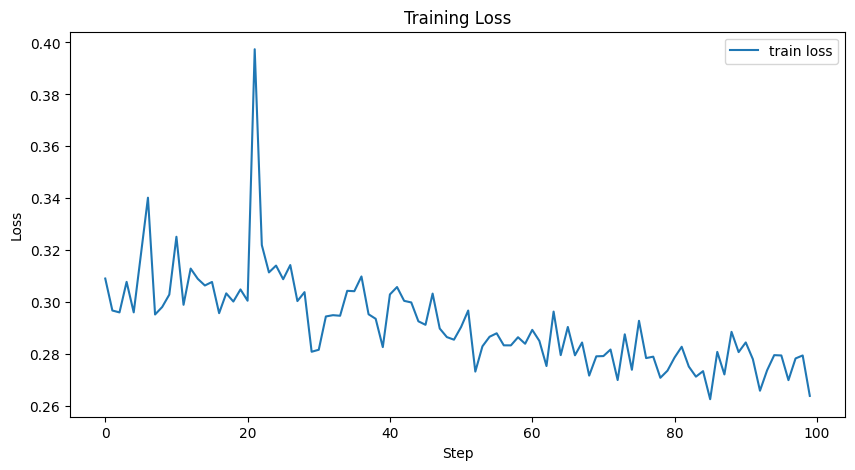

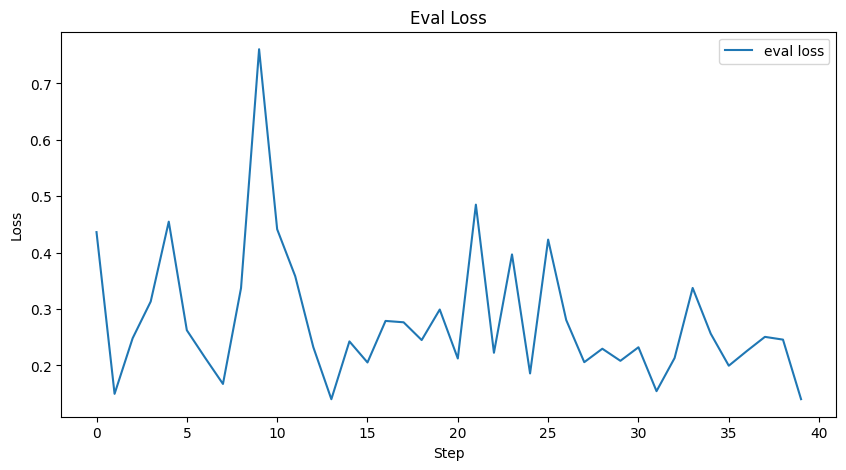

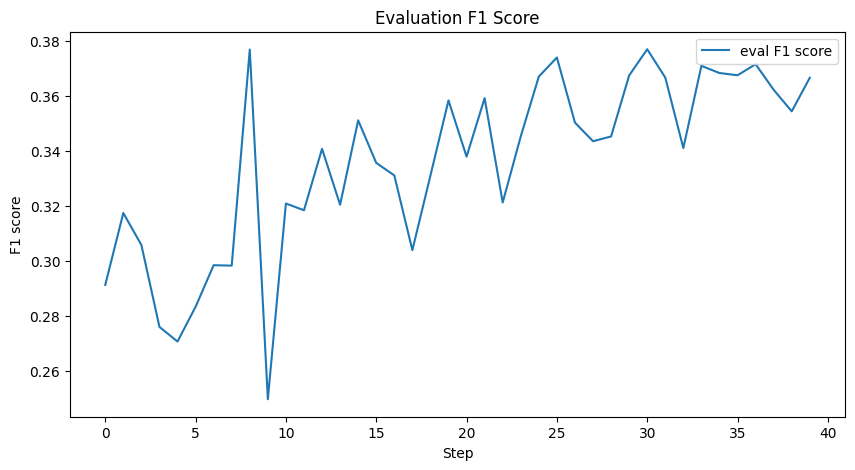

In [ ]:
# draw the training and evaluation loss
import matplotlib.pyplot as plt
# smooth training loss
avg_num = 100
train_loss_list_smooth = [sum(train_loss_list[begin_idx:begin_idx+avg_num])/len(train_loss_list[begin_idx:begin_idx+avg_num]) for begin_idx in range(0, len(train_loss_list), avg_num)]
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list_smooth, label="train loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(eval_loss_list, label="eval loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Eval Loss")
plt.legend()
plt.show()

# draw the evaluation F1 score
plt.figure(figsize=(10, 5))
plt.plot(eval_F1_score_list, label="eval F1 score")
plt.xlabel("Step")
plt.ylabel("F1 score")
plt.title("Evaluation F1 Score")
plt.legend()
plt.show()


# ProgressiveDialogueDataset Class (not used for now)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import bisect


class ProgressiveDialogueDataset(Dataset):
    def __init__(self, dialogue_data, utterance_name="UtteranceID", emotion_name="EmotionID", max_length=None, utterance_padding_token_id=0, query_id=7, num_virtual_tokens=20):
        """
        Args:
            dialogue_data: A list of lists, where each inner list contains sentences
                           from one dialogue.
        """
        self.utterances = dialogue_data[utterance_name]
        self.emotions = dialogue_data[emotion_name]

        if max_length is None:
            max_length=0
            for utts in self.utterances:
                length = 0
                for utt in utts:
                    length += utt.shape[-1]+num_virtual_tokens
                if length > max_length:
                    max_length = length
        self.max_length = max_length

        self.query_id = query_id
        self.utterance_padding_token_id = utterance_padding_token_id
        self.num_virtual_tokens = num_virtual_tokens


        self.cumulative_sentence_counts = []
        self.row_lengths = [len(row) for row in self.utterances]
        self.total_sentences = 0
        for length in self.row_lengths:
            self.total_sentences += length
            self.cumulative_sentence_counts.append(self.total_sentences)

    def __len__(self):
        return self.total_sentences

    def __getitem__(self, idx):

        # Find which row this index belongs to
        row_index = bisect.bisect_right(self.cumulative_sentence_counts, idx)

        # Find the index of the sentence within that row
        sentence_index = idx - self.cumulative_sentence_counts[row_index]

        # Get the progressive sequence of sentences, save space for virtual tokens and concatenate every sentence
        utterances = self.utterances[row_index][:sentence_index + 1]
        utterance_lengths = [utt.shape[-1] for utt in utterances]

        # calculate the desired length of the utterance
        begin_index = len(utterance_lengths)
        cumulative_length = 0
        for i in range(len(utterance_lengths)-1,0-1, -1):
            # add virtual token space to the beginning of the sentence
            utterances[i] = torch.cat([ torch.full((self.num_virtual_tokens,), self.utterance_padding_token_id, dtype=torch.long), 
                                        utterances[i]], dim=1)
            cumulative_length += utterance_lengths[i]+self.num_virtual_tokens
            if cumulative_length > self.max_length:
                break
            begin_index = i
        # concatenate the sentences
        if begin_index == len(utterance_lengths):
            # if the first sentence is too long, we need to truncate it
            utterance = utterances[-1][:self.max_length]
            emotions = [self.query_id]
            attention_mask = torch.ones((self.max_length,), dtype=torch.long)

        else:
            utterance = torch.cat(utterances[begin_index:], dim=1)
            emotions = self.emotions[row_index][begin_index:sentence_index]
            emotions = emotions + [self.query_id]
            attention_mask = torch.ones((utterance.shape[-1],), dtype=torch.long)
            attention_mask = torch.cat([attention_mask, torch.zeros((self.max_length - utterance.shape[-1],), dtype=torch.long)], dim=1)
            utterance = torch.cat([utterance, torch.full((self.max_length - utterance.shape[-1],), self.utterance_padding_token_id, dtype=torch.long)], dim=1)

        labels = self.emotions[row_index][sentence_index]

        return {
            "UtteranceID": utterance,
            "EmotionID": emotions,
            "AttentionMask": attention_mask,
            "Label": labels,
        }




# T5-Large

## train

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )

    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")

In [ ]:
correct = 0
total = 0
for pred, true in zip(eval_preds, dataset["validation"]["text_label"]):
    if pred.strip() == true.strip():
        correct += 1
    total += 1
accuracy = correct / total * 100
print(f"{accuracy=} % on the evaluation dataset")
print(f"{eval_preds[:10]=}")
print(f"{dataset['validation']['text_label'][:10]=}")

# Llama-4

In [ ]:
# Apply prefix tuning to solve the emotion recognition task
# First, do the language modeling task with prefix tuning
# The prefix are the emotions in the dataset, and the model will learn to predict the next word based on the prefix
# There's also an additional prefix for answering the emotion recognition task.


model_id = "meta-llama/Llama-4-Scout-17B-16E-Instruct"

processor = AutoProcessor.from_pretrained(model_id)
model = Llama4ForConditionalGeneration.from_pretrained(
    model_id,
    attn_implementation="flex_attention",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": train_df["Emotion"][0]},
            {"type": "text", "text": train_df["Utterance"][0]},
        ]
    },
]
inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
)
# def get_data_loader(df, processor, max_length=128, batch_size=4):
#     """
#     Create a DataLoader for the dataset.
#     """
#     def encode(examples):
#         return processor(
#             examples["Emotion"],
#             examples["Utterance"],
#             truncation=True,
#             max_length=max_length,
#             padding="max_length",
#         )

#     # Encode the dataset
#     encoded_dataset = df.apply(encode, axis=1).tolist()
    
#     # Create DataLoader
#     data_loader = DataLoader(
#         encoded_dataset,
#         batch_size=batch_size,
#         collate_fn=default_data_collator
#     )
    
#     return data_loader

